In [1]:
# Import
# Data & NLP
import re
import pandas as pd
import numpy as np
import inflect

# HuggingFace
import torch
from transformers import AutoTokenizer, AutoModel

# TF/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Plot
import matplotlib.pyplot as plt


c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Pembersihan Dataset
p = inflect.engine()

def convert_numbers_to_words(text):
    return " ".join([p.number_to_words(w) if w.isdigit() else w for w in str(text).split()])

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = convert_numbers_to_words(text)
    return text

# Load dataset
train_raw = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-train.csv")
test_raw  = pd.read_csv(r"C:\Users\User\Desktop\Skripsi\Program_Skripsi\Eksperimen1\data\dreaddit-test.csv")

# Cleaning
train_clean = train_raw.copy()
test_clean  = test_raw.copy()
train_clean["cleaned_text"] = train_clean["text"].map(clean_text)
test_clean["cleaned_text"]  = test_clean["text"].map(clean_text)

# Variabel khusus
X_train_text = train_clean["cleaned_text"].tolist()
X_test_text  = test_clean["cleaned_text"].tolist()
y_train = train_clean["label"].to_numpy()
y_test  = test_clean["label"].to_numpy()

train_clean[["text","cleaned_text","label"]].head()

,text,cleaned_text,label
0,"He said he had not felt that way before, sugge...",he said he had not felt that way before sugget...,1
1,"Hey there r/assistance, Not sure if this is th...",hey there r assistance not sure if this is the...,0
2,My mom then hit me with the newspaper and it s...,my mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",until i met my new boyfriend he is amazing he ...,1
4,October is Domestic Violence Awareness Month a...,october is domestic violence awareness month a...,1


In [3]:
# Ekstraksi Fitur MentalBERT
HF_MODEL_NAME = "mental/mental-bert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
model = AutoModel.from_pretrained(HF_MODEL_NAME)

def get_embeddings(texts):
    embs = []
    for t in texts:
        enc = tokenizer(t, max_length=MAX_LEN, truncation=True, padding="max_length", return_tensors="pt")
        with torch.no_grad():
            out = model(**enc)
        cls = out.last_hidden_state[:,0,:].numpy()
        embs.append(cls)
    stacked = np.vstack(embs)               # (N,768)
    return np.expand_dims(stacked, axis=1)  # (N,1,768)

X_train_bert = get_embeddings(X_train_text)
X_test_bert  = get_embeddings(X_test_text)

print("MentalBERT embeddings:", X_train_bert.shape, X_test_bert.shape)

c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MentalBERT embeddings: (2838, 1, 768) (715, 1, 768)


In [4]:
# Ekstraksi Fitur TF-IDF
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf  = vectorizer.transform(X_test_text)

print("TF-IDF features:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF features: (2838, 30000) (715, 30000)


In [5]:
# Convert sparse TF-IDF ke dense array lalu reshape untuk CNN
X_train_tfidf = X_train_tfidf.toarray().reshape((X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1))
X_test_tfidf  = X_test_tfidf.toarray().reshape((X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1))

print("X_train_tfidf reshaped:", X_train_tfidf.shape)
print("X_test_tfidf reshaped:", X_test_tfidf.shape)

X_train_tfidf reshaped: (2838, 30000, 1)
X_test_tfidf reshaped: (715, 30000, 1)


In [6]:
# model CNN untuk MentalBERT
def build_cnn_bert(input_shape):
    model = Sequential([
        Conv1D(128, 1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

cnn_bert = build_cnn_bert((1,768))
cnn_bert.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            98432     
                                                                 
 batch_normalization (Batch  (None, 1, 128)            512       
 Normalization)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                

In [7]:
# Model untuk TF-IDF
# TF-IDF bentuknya sparse matrix (N, F), bukan (N,1,768)
# Supaya adil, kita buat CNN-like tapi 1D → perlu reshape ke (N, F, 1)
from tensorflow.keras.layers import Flatten, InputLayer

input_shape = (X_train_tfidf.shape[1], 1)  # (30000, 1)

def build_cnn_tfidf(input_shape):
    model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Kalau X_train_tfidf sudah numpy array
X_train_tfidf_cnn = np.expand_dims(X_train_tfidf, axis=-1)
X_test_tfidf_cnn  = np.expand_dims(X_test_tfidf, axis=-1)

print("X_train_tfidf_cnn:", X_train_tfidf_cnn.shape)
print("X_test_tfidf_cnn:", X_test_tfidf_cnn.shape)

cnn_tfidf = build_cnn_tfidf((X_train_tfidf_cnn.shape[1], 1))
cnn_tfidf.summary()


X_train_tfidf_cnn: (2838, 30000, 1, 1)
X_test_tfidf_cnn: (715, 30000, 1, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 29998, 128)        512       
                                                                 
 batch_normalization_2 (Bat  (None, 29998, 128)        512       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                            

In [8]:
# Training
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train CNN MentalBERT
hist_bert = cnn_bert.fit(
    X_train_bert, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=8,
    callbacks=[es, rl],
    verbose=1
)

# Train CNN TF-IDF
hist_tfidf = cnn_tfidf.fit(
    X_train_tfidf_cnn, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=8,
    callbacks=[es, rl],
    verbose=1
)

Epoch 1/20


284/284 [==============================] - 6s 8ms/step - loss: 1.4031 - accuracy: 0.6819 - val_loss: 0.9416 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 2/20
284/284 [==============================] - 2s 6ms/step - loss: 1.1040 - accuracy: 0.7084 - val_loss: 0.7670 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 3/20
284/284 [==============================] - 2s 6ms/step - loss: 0.9033 - accuracy: 0.7414 - val_loss: 0.6730 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 4/20
284/284 [==============================] - 2s 5ms/step - loss: 0.7949 - accuracy: 0.7586 - val_loss: 0.5972 - val_accuracy: 0.8363 - lr: 0.0010
Epoch 5/20
284/284 [==============================] - 2s 6ms/step - loss: 0.6999 - accuracy: 0.7608 - val_loss: 0.5479 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 6/20
284/284 [==============================] - 2s 6ms/step - loss: 0.6572 - accuracy: 0.7630 - val_loss: 0.5143 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 7/20
284/284 [==============================] - 2s 6ms/step - 

23/23 [==============================] - 1s 2ms/step
== CNN + MentalBERT ==
              precision    recall  f1-score   support

      NotDep       0.82      0.77      0.80       346
         Dep       0.80      0.84      0.82       369

    accuracy                           0.81       715
   macro avg       0.81      0.81      0.81       715
weighted avg       0.81      0.81      0.81       715



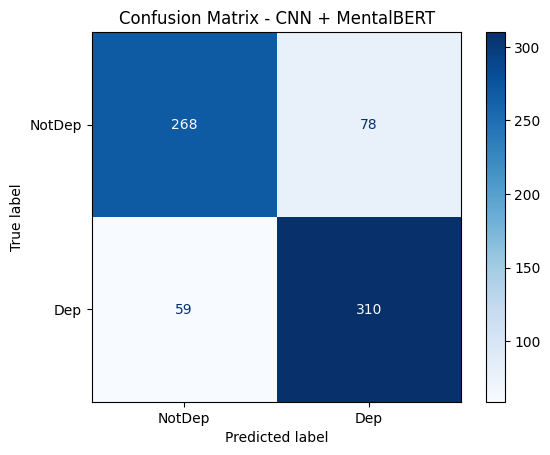

23/23 [==============================] - 5s 230ms/step
== CNN + TF-IDF ==
              precision    recall  f1-score   support

      NotDep       0.52      0.40      0.45       346
         Dep       0.53      0.65      0.59       369

    accuracy                           0.53       715
   macro avg       0.52      0.52      0.52       715
weighted avg       0.53      0.53      0.52       715



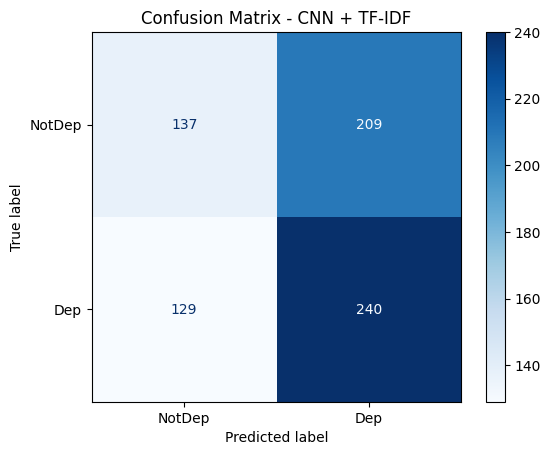

In [9]:
# evaluasi
def evaluate_model(model, X_test, y_test, title=""):
    preds = (model.predict(X_test) >= 0.5).astype(int).ravel()
    print(f"== {title} ==")
    print(classification_report(y_test, preds, target_names=["NotDep","Dep"]))
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["NotDep","Dep"])
    disp.plot(cmap="Blues"); plt.title(f"Confusion Matrix - {title}"); plt.show()

evaluate_model(cnn_bert, X_test_bert, y_test, "CNN + MentalBERT")
evaluate_model(cnn_tfidf, X_test_tfidf_cnn, y_test, "CNN + TF-IDF")


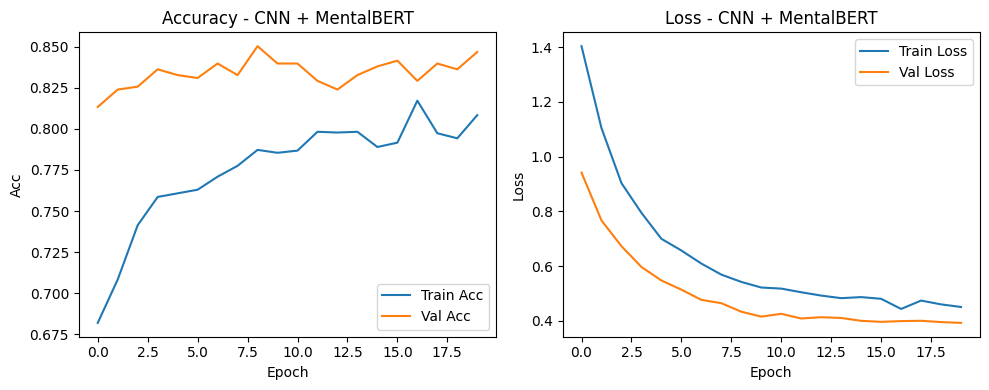

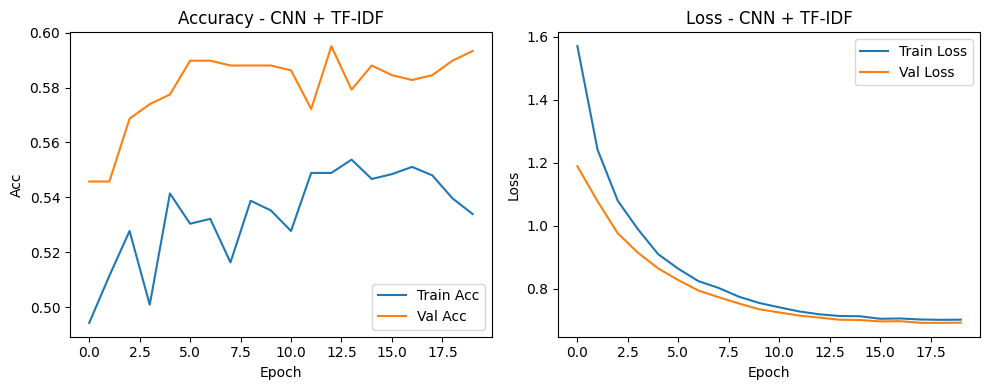

In [10]:
# Visualisasi dan Perbandingan
def plot_history(hist, title=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history.get("accuracy",[]), label="Train Acc")
    plt.plot(hist.history.get("val_accuracy",[]), label="Val Acc")
    plt.title(f"Accuracy - {title}"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history.get("loss",[]), label="Train Loss")
    plt.plot(hist.history.get("val_loss",[]), label="Val Loss")
    plt.title(f"Loss - {title}"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout(); plt.show()

plot_history(hist_bert, "CNN + MentalBERT")
plot_history(hist_tfidf, "CNN + TF-IDF")

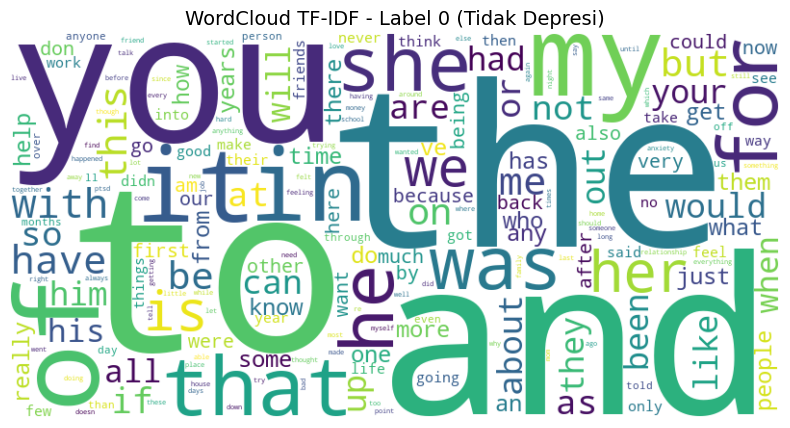

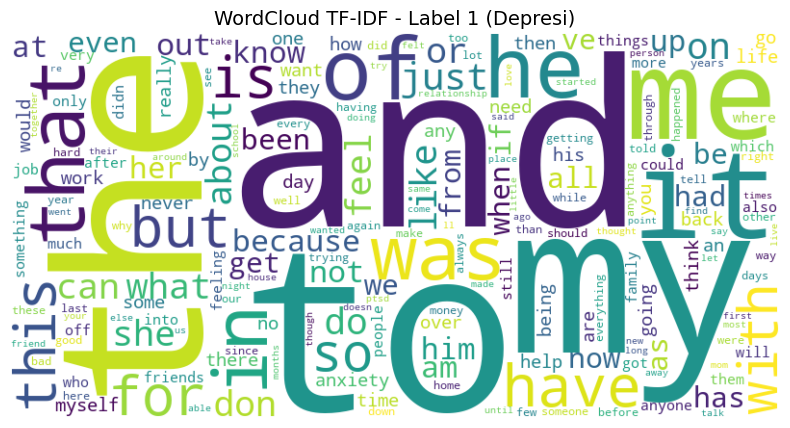

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# === TF-IDF untuk seluruh dataset (train_df sudah ada dari pipeline eksperimen 2) ===
vectorizer = TfidfVectorizer(max_features=200)  # ambil 200 kata teratas biar tidak terlalu ramai
X_tfidf = vectorizer.fit_transform(train_clean['text'])
feature_names = vectorizer.get_feature_names_out()

# Konversi ke DataFrame
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names, index=train_clean.index)

# === Bagi berdasarkan label ===
df_tfidf_0 = df_tfidf[train_clean['label'] == 0]  # Tidak Depresi
df_tfidf_1 = df_tfidf[train_clean['label'] == 1]  # Depresi

# Hitung rata-rata bobot kata per kelas
tfidf_mean_0 = df_tfidf_0.mean(axis=0).to_dict()
tfidf_mean_1 = df_tfidf_1.mean(axis=0).to_dict()

# === WordCloud untuk label 0 (Tidak Depresi) ===
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_mean_0)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud TF-IDF - Label 0 (Tidak Depresi)", fontsize=14)
plt.show()

# === WordCloud untuk label 1 (Depresi) ===
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_mean_1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud TF-IDF - Label 1 (Depresi)", fontsize=14)
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_21900\1002099309.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(words), palette="viridis")


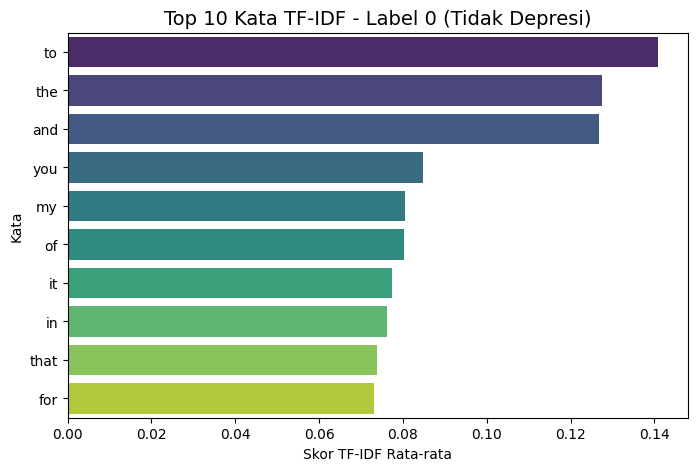

C:\Users\User\AppData\Local\Temp\ipykernel_21900\1002099309.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(words), palette="viridis")


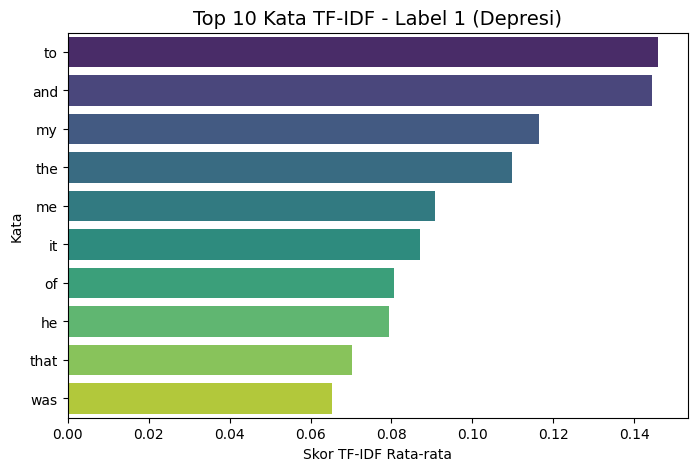

In [12]:
import seaborn as sns

def plot_top_tfidf_words(tfidf_dict, label_name, top_n=10):
    # Ambil top-n kata dengan skor tertinggi
    sorted_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    words, scores = zip(*sorted_items)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(scores), y=list(words), palette="viridis")
    plt.title(f"Top {top_n} Kata TF-IDF - Label {label_name}", fontsize=14)
    plt.xlabel("Skor TF-IDF Rata-rata")
    plt.ylabel("Kata")
    plt.show()

# Plot untuk masing-masing kelas
plot_top_tfidf_words(tfidf_mean_0, "0 (Tidak Depresi)", top_n=10)
plot_top_tfidf_words(tfidf_mean_1, "1 (Depresi)", top_n=10)


In [22]:
# === Setting tampilan Pandas agar teks tidak terpotong ===
import pandas as pd

# tampilkan teks full (tidak dipotong dengan ...)
pd.set_option("display.max_colwidth", None)

# tampilkan lebih banyak baris (default 10)
pd.set_option("display.max_rows", 100)

# tampilkan lebih banyak kolom kalau DataFrame lebar
pd.set_option("display.max_columns", 20)

print("Pandas display options set: full text, max_rows=100, max_columns=20")

Pandas display options set: full text, max_rows=100, max_columns=20


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer
import pandas as pd

# === Ambil 1 contoh teks dari dataset ===
sample_text = train_clean['cleaned_text'].iloc[0]

# === TF-IDF Tokenization ===
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit([sample_text])
tfidf_tokens = tfidf_vectorizer.get_feature_names_out()
tfidf_weights = tfidf_vectorizer.transform([sample_text]).toarray()[0]

# Gabungkan token dan bobot TF-IDF ke string
tfidf_tokens_str = str(list(tfidf_tokens))
tfidf_weights_str = str([round(w, 3) for w in tfidf_weights])

# === MentalBERT Tokenization ===
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=150,        # panjang tetap 300
    padding="max_length",  # aktifkan padding sampai max_length
    truncation=True,
    return_tensors="pt"
)

tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
ids = encoding['input_ids'][0].tolist()

# Gabungkan token dan ID MentalBERT ke string
bert_tokens_str = str(tokens)
bert_ids_str = str(ids)

# === Buat DataFrame tampilan horizontal ===
df_side = pd.DataFrame([
    ["TF-IDF", sample_text, tfidf_tokens_str, tfidf_weights_str],
    ["MentalBERT", sample_text, bert_tokens_str, bert_ids_str]
], columns=["Metode", "Teks hasil preprocessing", "Kata yang ditokenisasi", "Representasi Numerik"])

display(df_side)

c:\Users\User\Desktop\Skripsi\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Metode,Teks hasil preprocessing,Kata yang ditokenisasi,Representasi Numerik
0,TF-IDF,he said he had not felt that way before suggeted i go rest and so trigger ahead if youi re a hypocondriac like me i decide to look up feelings of doom in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy a stupid are you psychic test or new age b s something i could even laugh at down the road no i ended up reading that this sense of doom can be indicative of various health ailments one of which i am prone to so on top of my doom to my gloom i am now f n worried about my heart i do happen to have a physical in forty-eight hours,"['about', 'age', 'ahead', 'ailments', 'am', 'and', 'are', 'at', 'be', 'before', 'can', 'conspiracy', 'could', 'decide', 'do', 'doom', 'down', 'eight', 'ended', 'even', 'feelings', 'felt', 'forty', 'getting', 'gloom', 'go', 'had', 'happen', 'have', 'he', 'health', 'heart', 'hole', 'hopes', 'hours', 'hypocondriac', 'if', 'in', 'indicative', 'into', 'laugh', 'like', 'look', 'ludicrous', 'maybe', 'me', 'my', 'new', 'no', 'not', 'now', 'of', 'on', 'one', 'or', 'physical', 'prone', 'psychic', 'rabbit', 're', 'reading', 'rest', 'road', 'said', 'sense', 'so', 'some', 'something', 'stupid', 'sucked', 'suggeted', 'test', 'that', 'the', 'this', 'to', 'top', 'trigger', 'up', 'various', 'way', 'which', 'worried', 'you', 'youi']","[0.074, 0.074, 0.074, 0.074, 0.148, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.222, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.148, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.148, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.222, 0.074, 0.074, 0.074, 0.074, 0.519, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.148, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074, 0.148, 0.074, 0.074, 0.296, 0.074, 0.074, 0.148, 0.074, 0.074, 0.074, 0.074, 0.074, 0.074]"
1,MentalBERT,he said he had not felt that way before suggeted i go rest and so trigger ahead if youi re a hypocondriac like me i decide to look up feelings of doom in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy a stupid are you psychic test or new age b s something i could even laugh at down the road no i ended up reading that this sense of doom can be indicative of various health ailments one of which i am prone to so on top of my doom to my gloom i am now f n worried about my heart i do happen to have a physical in forty-eight hours,"['[CLS]', 'he', 'said', 'he', 'had', 'not', 'felt', 'that', 'way', 'before', 'su', '##gg', '##ete', '##d', 'i', 'go', 'rest', 'and', 'so', 'trigger', 'ahead', 'if', 'you', '##i', 're', 'a', 'h', '##yp', '##oco', '##nd', '##ria', '##c', 'like', 'me', 'i', 'decide', 'to', 'look', 'up', 'feelings', 'of', 'doom', 'in', 'hopes', 'of', 'maybe', 'getting', 'sucked', 'into', 'some', 'rabbit', 'hole', 'of', 'lu', '##dic', '##rous', 'conspiracy', 'a', 'stupid', 'are', 'you', 'psychic', 'test', 'or', 'new', 'age', 'b', 's', 'something', 'i', 'could', 'even', 'laugh', 'at', 'down', 'the', 'road', 'no', 'i', 'ended', 'up', 'reading', 'that', 'this', 'sense', 'of', 'doom', 'can', 'be', 'indicative', 'of', 'various', 'health', 'ai', '##lm', '##ents', 'one', 'of', 'which', 'i', 'am', 'prone', 'to', 'so', 'on', 'top', 'of', 'my', 'doom', 'to', 'my', 'gloom', 'i', 'am', 'now', 'f', 'n', 'worried', 'about', 'my', 'heart', 'i', 'do', 'happen', 'to', 'have', 'a', 'physical', 'in', 'forty', '-', 'eight', 'hours', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']","[101, 2002, 2056, 2002, 2018, 2025, 2371, 2008, 2126, 2077, 10514, 13871, 12870, 2094, 1045, 2175, 2717, 1998, 2061, 9495, 3805, 2065, 2017, 2072, 2128, 1037, 1044, 22571, 24163, 4859, 4360, 2278, 2066, 2033, 1045, 5630, 2000, 2298, 2039, 5346, 1997, 12677, 1999, 8069, 1997, 2672, 2893, 8631,

In [23]:
# Hitung jumlah kata per dokumen (hasil preprocessing)
train_clean['word_count'] = train_clean['cleaned_text'].apply(lambda x: len(x.split()))

# Dokumen dengan kata terbanyak
max_words = train_clean['word_count'].max()
longest_doc = train_clean.loc[train_clean['word_count'].idxmax(), 'cleaned_text']

print("Jumlah kata terbanyak dalam 1 dokumen:", max_words)
print("\n=== Contoh dokumen terpanjang ===\n")
print(longest_doc)

# Statistik distribusi panjang kata
print("\nStatistik distribusi panjang teks:")
print(train_clean['word_count'].describe())

Jumlah kata terbanyak dalam 1 dokumen: 319

=== Contoh dokumen terpanjang ===

i was severely neglected as a child by my mother but this isn t about the neglect although it may make an appearance at some point i think my twin and i were sexually abused by her first boyfriend the man she had an affair with i have a distinct memory of lying in my bed at night and there being a male figure crawling up towards me this is more of a still frame though the others however i remember vividly to a point one was a very inappropriate tickling game where my sister was under her duvet and he was on top of her tickling except he was also humping i can t remember much more than that the other is walking to his house i remember the exact route going in and him showing me his house i can t remember anything once he showed me his bedroom other than the bedding was white i don t remember leaving or what happened in between but i remember things like he had an eiffel tower figure he made in his front room 